In [ ]:
!pip install swig
!pip install ufal.pybox2d
!pip install gym[box2d]

In [ ]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make("LunarLander-v2").env
env.reset()
n_actions = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ __(5 pts)__ Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ __(bonus: 5 pts each)__ Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params), show graphs for different params
  
  
### Tips
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue.
* 20-neuron network is probably not enough, feel free to experiment.

In [ ]:
def generate_session(agent, t_max=10000):

    states,actions = [],[]
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        probs = agent.predict_proba([s])
        probs = np.reshape(probs, -1)

        a = np.random.choice(np.arange(n_actions), p=probs)

        new_s,r,done,info = env.step(a)

        #record sessions like you did before

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
           break
    return states,actions,total_reward


In [ ]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(128, 128, 32),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
agent.fit([env.reset()]*n_actions,range(n_actions));

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
from IPython.display import clear_output

def show_progress(rewards_batch,log, reward_range=[-5000,+5000]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    #print(rewards_batch)
    reward_range=[-1010,+10]
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []

    n_session = len(states_batch)

    ind = np.arange(n_session)

    ind = ind[rewards_batch[ind] >= reward_threshold]


    elite_states = [states_batch[i] for i in ind]
    elite_actions = [actions_batch[i] for i in ind]

    if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)
    elite_actions = np.hstack(elite_actions)

    return elite_states,elite_actions

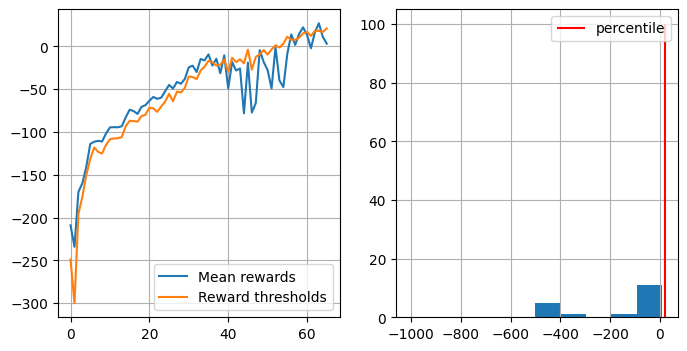

Time: 16225.032806634903


In [ ]:
import time
n_sessions = 100
percentile = 30
log = []
startTime = time.time()

for i in range(10000):
    #generate new sessions
    sessions = [generate_session(agent) for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = map(list,zip(*sessions))

    rewards_batch = np.array(rewards_batch)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile)

    agent.fit(elite_states, elite_actions)


    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])

    print("Time:", time.time() - startTime)

    if (rewards_batch.mean() > 50):
        print("Win!")
        break

print("Time:", time.time() - startTime)
    #if np.mean(rewards_batch)> 190:
     #   print("You Win! You may stop training now via KeyboardInterrupt.")

# **Многопоточность**

In [ ]:
from joblib import Parallel, delayed


In [ ]:
import time
n_sessions = 100
percentile = 30
log = []
startTime = time.time()

agent = MLPClassifier(hidden_layer_sizes=(128, 128, 32),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )

for i in range(10000):
    #generate new sessions
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(agent) for _ in range(n_sessions))

    states_batch,actions_batch,rewards_batch = map(list,zip(*sessions))

    rewards_batch = np.array(rewards_batch)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile)

    agent.fit(elite_states, elite_actions)


    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])

    print("Time:", time.time() - startTime)

    if (rewards_batch.mean() > 50):
        print("Win!")
        break

print("Time:", time.time() - startTime)
    #if np.mean(rewards_batch)> 190:
     #   print("You Win! You may stop training now via KeyboardInterrupt.")

# Переиспользование последних 3-5 операций

In [ ]:
import time
n_sessions = 100
percentile = 30
log = []
startTime = time.time()

st = []
ac = []
rw = []

agent = MLPClassifier(hidden_layer_sizes=(128, 128, 32),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )

for i in range(10000):
    #generate new sessions
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)(agent) for _ in range(n_sessions))

    states_batch,actions_batch,rewards_batch = map(list,zip(*sessions))

    st.append(states_batch)
    ac.append(actions_batch)
    rw.append(rewards_batch)


    rewards_batch = np.array(rewards_batch)

    v1 = []
    v2 = []
    v3 = []

    for i in range(len(st)):
      for v in st[i]:
          v1.append(v)
      for v in ac[i]:
          v2.append(v)
      for v in rw[i]:
          v3.append(v)


    elite_states, elite_actions = select_elites(v1,v2,np.array(v3),percentile)

    agent.fit(elite_states, elite_actions)


    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])

    print("Time:", time.time() - startTime)

    if (rewards_batch.mean() > 50):
        print("Win!")
        break

    if i >= 3:
        del st[0]
        del ac[0]
        del rw[0]

print("Time:", time.time() - startTime)
    #if np.mean(rewards_batch)> 190:
     #   print("You Win! You may stop training now via KeyboardInterrupt.")

Делал вместе с Тимуром Лузговым, наставлял Антон Никифоров.